## Env Development  
This will contain tests for developing environment.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import functools
import os
import time

from absl import app
from absl import logging

import gin
from six.moves import range
import tensorflow as tf  # pylint: disable=g-explicit-tensorflow-version-import

import matplotlib
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
#plt.ioff() 

from tf_agents.agents.ddpg import actor_rnn_network
from tf_agents.agents.ddpg import critic_rnn_network
from tf_agents.agents.ddpg import ddpg_agent
from tf_agents.drivers import dynamic_episode_driver
from tf_agents.environments import suite_dm_control
from tf_agents.environments import tf_py_environment
from tf_agents.environments import py_environment
from tf_agents.environments import wrappers
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.utils import common

import numpy as np
from tf_agents.environments import utils
from tf_agents.trajectories.time_step import StepType
from tf_agents.trajectories import TimeStep
from tf_agents.policies import scripted_py_policy
from tf_agents.policies import random_py_policy
from tf_agents.policies import policy_saver
from tf_agents.metrics import py_metrics
from tf_agents.drivers import py_driver
from tf_agents.specs import tensor_spec
from tf_agents.networks import sequential

from Env import Env
max_episode_length=1000
num_herds = 2
total_population = 300

In [2]:
py_env = Env(num_herds = num_herds, total_population = total_population, fix_episode_length=True, average_episode_length = 100)

First, test environment input and output.

In [3]:
zero_step = py_env.reset()
print('Reset: ', zero_step)
for i in range (0,10):
    step = py_env.step([1.,1.,0.,0.])
    print('Step: ', step)

Reset:  TimeStep(
{'discount': 1.0,
 'observation': array([0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 'reward': 0.0,
 'step_type': array(0, dtype=int32)})
Step:  TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([0.01, 0.01, 0.  , 0.  , 0.01, 0.  , 0.  ], dtype=float32),
 'reward': array(-1.068593, dtype=float32),
 'step_type': array(1, dtype=int32)})
Step:  TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([0.02, 0.02, 0.  , 0.  , 0.02, 0.  , 0.  ], dtype=float32),
 'reward': array(-2.3114612, dtype=float32),
 'step_type': array(1, dtype=int32)})
Step:  TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([0.03, 0.03, 0.  , 0.  , 0.03, 0.  , 0.  ], dtype=float32),
 'reward': array(-3.6544127, dtype=float32),
 'step_type': array(1, dtype=int32)})
Step:  TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([0.04      , 0.03      , 0.88666666, 0.11333334, 0.03      ,
       0.98      , 0.02      ], dtype=flo

Define two scripted policies:

In [4]:
# Define t

action_script1 = [(10, [0,0,0,0]), 
                 (1, [0,0,1,1]),
                 (10, [0,0,0,0]), 
                 (1, [0,0,1,1])] * int(1+max_episode_length)

scr_pol_1 = scripted_py_policy.ScriptedPyPolicy(
    time_step_spec=py_env.time_step_spec(),
    action_spec=py_env.action_spec(),
    action_script=action_script1)

action_script2 = [(7, [0,0,0,0]), 
                 (1, [0,0,1,1]),
                 (7, [0,0,0,0]), 
                 (1, [0,0,1,1])] * int(1+max_episode_length)

scr_pol_2 = scripted_py_policy.ScriptedPyPolicy(
    time_step_spec=py_env.time_step_spec(),
    action_spec=py_env.action_spec(),
    action_script=action_script2)

And create a random policy:

In [5]:
random_policy = random_py_policy.RandomPyPolicy(time_step_spec=py_env.time_step_spec(), 
                                                action_spec=py_env.action_spec())

Now write a function that tests an environment with any policy.  
Outputs average return over a set number of episodes and average steps where the agent culled one or more herds.

In [6]:
def test_rnn_env(environment, policy, num_episodes=50):
    if isinstance(environment, py_environment.PyEnvironment):
        total_return = 0.0
        cullsteps = 0 
        for e in range(num_episodes):

            time_step = environment.reset()
            if isinstance(policy, scripted_py_policy.ScriptedPyPolicy):
                policy_state = policy.get_initial_state() # remember where in the script we were
            else:
                #print(policy.get_initial_state(batch_size=train_env.batch_size()))
                policy_state = policy.get_initial_state(batch_size=1) # other policies without memory
            episode_return = 0.0
            i=0
            while not time_step.is_last():
                i+=1
                action_step = policy.action(time_step, policy_state)
                for i in range (num_herds, num_herds*2):
                    if action_step.action[i] > 0:
                        cullsteps += 1
                        
                policy_state = action_step.state
                time_step = environment.step(action_step.action)

                episode_return += time_step.reward

            total_return += episode_return

        avg_return = total_return / num_episodes
        cullsteps /= num_episodes
        return avg_return, cullsteps
    else:
        return None

At this point, use the policies for stress testing.

In [7]:
avg_return, culls = test_rnn_env(py_env, scr_pol_1, num_episodes = 200)
culls /= 2
print('average return = {0} cullsteps = {1}'.format(avg_return, culls))

average return = -4336.004935503402 cullsteps = 9.0


In [8]:
avg_return, culls = test_rnn_env(py_env, scr_pol_2, num_episodes = 200)
culls /= 2
print('average return = {0} cullsteps = {1}'.format(avg_return, culls))

average return = -4287.3925736302135 cullsteps = 12.0


In [9]:
avg_return, culls = test_rnn_env(py_env, random_policy , num_episodes = 200)
culls /= 2
print('average return = {0} cullsteps = {1}'.format(avg_return, culls))

average return = -14365.294085966796 cullsteps = 100.0


Additionally, run a Pseudo-Agent.

In [10]:
def PseudoAgent(env, num_episodes):
    assert num_episodes >= 0, "Please enter a positive integer for episode number."
    
    # Outputs
    total_culls_h1 = 0
    total_culls_h2 = 0
    total_return = 0.
    
    for i in range (0, num_episodes):
        time_step = env.reset()
        counter = 0
        episode_return = 0.
        cw_1 = 0
        while not time_step.is_last():
            act = [0.,0.,0.,0.]
            if counter % 3 == 0:
                act[0] = 0.5
                act[1] = 0.5
            counter += 1
            # 3/epl because of 3 weeks until testresults
            if (time_step.observation[3] >= 0.07 or time_step.observation[6] >= 0.07) and cw_1 >= 5:
                act[2] = 1.
                act[3] = 1.
                total_culls_h1 += 1
                cw_1 = 0
            else:
                cw_1 += 1
            time_step = env.step(act)
            episode_return += time_step.reward
        total_return += episode_return
        
    avg_culls_h2 = total_culls_h2 / num_episodes
    avg_culls_h1 = total_culls_h1 / num_episodes
    avg_return = total_return / num_episodes
    return avg_culls_h1, avg_culls_h2, avg_return

In [11]:
c1,c2,ar = PseudoAgent(py_env, 200)
print('Average culls herd 1: ', c1)
print('Average culls herd 2: ', c2)
print('Average Return: ', ar)

Average culls herd 1:  8.79
Average culls herd 2:  0.0
Average Return:  -4759.979590873122


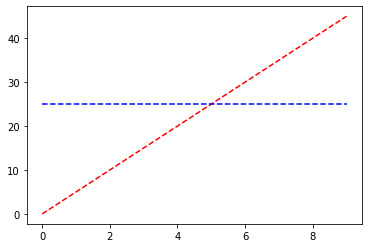

In [12]:
# Testing whether reward function values make sense
cull_cost = 2.5
herd_population = 10

pop = np.linspace(herd_population*cull_cost,herd_population*cull_cost,num=herd_population)
ran = np.arange(0, herd_population, 1)

plt.plot(ran, ran*5,'r--', ran, pop,'b--')

In [13]:
# Testing reward function for different herd sizes
